In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

* f é para usar as chavetas {} na string

* convert('L') é para tornas as fotografias greyscale (monocromático)

In [8]:
base = [Image.open(f'att/s{pasta}/{fig}.pgm').convert('L') for pasta in range(1, 41) for fig in range(1, 10)]

#### "Chama" a imagem

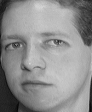

In [9]:
input_img = Image.open(f'att/s1/4.pgm').convert('L')
input_img

#### Saber a quantidade de fotografias que existem

In [10]:
M = len(base)
M

360

#### Gera uma lista de listas em que cada lista corresponde a uma imagem (0 a 399)

In [11]:
X = np.array([base[i].getdata() for i in range(M)])

#### Temos 400 listas em que cada uma 10304 elementos

In [12]:
print(X.shape)
X

(360, 10304)


array([[ 48,  49,  45, ...,  47,  46,  46],
       [ 60,  60,  62, ...,  32,  34,  34],
       [ 39,  44,  53, ...,  29,  26,  29],
       ...,
       [129, 127, 133, ...,  93,  93,  93],
       [125, 119, 124, ...,  36,  39,  40],
       [119, 120, 120, ...,  89,  94,  85]])

#### Centrar o X à média

In [13]:
media = np.mean(X, 0)
phi = X - media

In [14]:
media

array([85.46944444, 85.39722222, 85.75      , ..., 77.76388889,
       76.80833333, 75.65555556])

In [15]:
phi.shape

(360, 10304)

* e_faces : vetores singulares
* sigma : valores singulares
* Não vamos usar o v pelo que metemos como "_"

In [16]:
e_faces, sigma, _ = np.linalg.svd(phi.transpose(), full_matrices = False)

#### Os valores singulares são a raiz de um valor próprio, logo:

In [17]:
val_prop = sigma*sigma

#### Ordenar os valores próprios de forma decrescente

In [18]:
val_prop = np.sort(val_prop)
# o sort dá a lista ordenada crescentemente
# queremos decrescentemente, daí o ::-1
val_prop = val_prop[::-1]

#### Traço da matriz de dispersão (soma de todos valores próprios)

In [19]:
traco = sum(val_prop)

#### Calcular o k consoante a confiança da soma dos k primeiros valores próprios.
* parar quando temos uma confiança mínima de 80%;
* parar quando começar a incrementar menos de 0.5% na confiança.

In [20]:
confianca_alvo = 0.9
k = 0
confianca = 0
confiancaAnt = 0

while confianca < confianca_alvo:
    confiancaAnt = confianca
    confianca = confianca + val_prop[k]/traco
    k += 1
    
    print('(confiança, valor próprio): ({0}, {1})'.format(confianca, k))
    
    if confianca - confiancaAnt < 0.005:# and confianca > 0.8:
        break
        
k, confianca

(confiança, valor próprio): (0.17602075355102015, 1)
(confiança, valor próprio): (0.3042427120526611, 2)
(confiança, valor próprio): (0.3701502746097275, 3)
(confiança, valor próprio): (0.43004636335438134, 4)
(confiança, valor próprio): (0.48181403379895155, 5)
(confiança, valor próprio): (0.5156409571283465, 6)
(confiança, valor próprio): (0.5396369424405144, 7)
(confiança, valor próprio): (0.5627667089211039, 8)
(confiança, valor próprio): (0.5827178445462503, 9)
(confiança, valor próprio): (0.6005345017744348, 10)
(confiança, valor próprio): (0.6146754289690152, 11)
(confiança, valor próprio): (0.6286326382727323, 12)
(confiança, valor próprio): (0.6398365080000064, 13)
(confiança, valor próprio): (0.6501350703072091, 14)
(confiança, valor próprio): (0.6597773912806204, 15)
(confiança, valor próprio): (0.6684477940594751, 16)
(confiança, valor próprio): (0.6769257041894268, 17)
(confiança, valor próprio): (0.6851149506446509, 18)
(confiança, valor próprio): (0.6924567925270453, 19)

(28, 0.7452610233296746)

#### Vamos ver onde se encontra o nosso k escolhido (método do cotovelo / elbow plot)

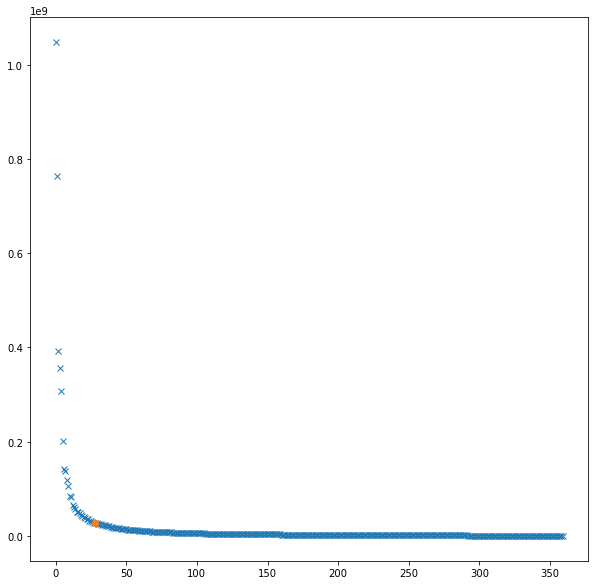

In [21]:
plt.figure(figsize = (10, 10))
t = np.arange(0, M, 1)
plt.plot(t, val_prop, 'x')
plt.plot(k, val_prop[k], 'o')
plt.show()

#### Queremos os k primeiros vetores próprios

In [22]:
newE_Faces = e_faces[:, 0:k]

In [23]:
phi.shape

(360, 10304)

In [24]:
newE_Faces.shape

(10304, 28)

In [25]:
coef_proj = [np.dot(phi[i], newE_Faces) for i in range(M)]

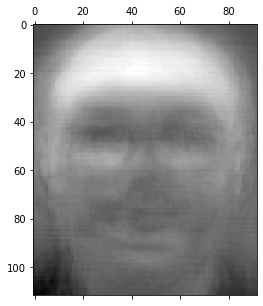

In [26]:
display(plt.matshow(np.reshape(newE_Faces.T[0], (112, 92)), cmap = 'gray'))

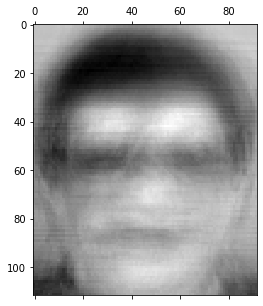

In [27]:
display(plt.matshow(np.reshape(newE_Faces.T[1], (112, 92)), cmap = 'gray'))

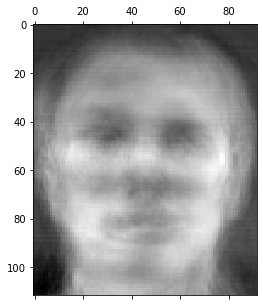

In [28]:
display(plt.matshow(np.reshape(newE_Faces.T[2], (112, 92)), cmap = 'gray'))

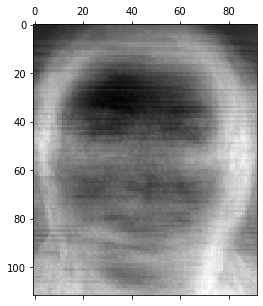

In [29]:
display(plt.matshow(np.reshape(newE_Faces.T[3], (112, 92)), cmap = 'gray'))

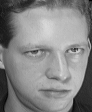

In [30]:
input_img = Image.open(f'att/1.pgm').convert('L')
input_img

In [31]:
gamma = np.array(input_img.getdata())

In [32]:
test_phi = gamma - media

In [33]:
test_coef_proj = np.dot(test_phi, newE_Faces)

In [34]:
test_coef_proj.shape

(28,)

In [35]:
def euclidian(coef_proj, test_coef_proj, M):
    dist = [np.linalg.norm(coef_proj[i] - test_coef_proj) for i in range(M)]
    return dist

In [36]:
def mahalanobis(coef_proj, test_coef_proj, val_prop, M):
    dist = [np.sum(np.divide(pow(coef_proj[i] - test_coef_proj, 2), val_prop)) for i in range(M)]
    return dist

In [37]:
def mahalanobisV2(coef_proj, test_coef_proj, val_prop, M):
    dist = []
    for i in range(M):
        dist.append(np.sum(np.divide((coef_proj[i]-test_coef_proj)**2, val_prop)))
    return dist

In [38]:
dist = euclidian(coef_proj, test_coef_proj, M)
distM = mahalanobis(coef_proj, test_coef_proj, val_prop[:k], M)
d_min = np.min(dist)
print(d_min)
print(np.min(distM))

2457.8829165129023
0.04853425511251502


In [39]:
print(len(dist))
print(len(distM))

360
360


In [40]:
d_min

2457.8829165129023

In [41]:
np.argmin(dist)

4

* Falta definir o limite para as duas distâncias quando tivermos as nossas fotos

In [42]:
def recognition(dist, typeDist):
    d_min = np.min(dist)
    
    if typeDist == 'euclidian':
        limite = 3000
    else:
        limite = 0.03
    
    if d_min < limite:
        # como temos 9 imagens por pasta
        pasta = int(np.floor(np.argmin(dist)/9)+1)
        print('Para a distância: ', typeDist)
        print('\tPasta s'f'{pasta}\n\tdist = {d_min}')
    else:
        print('Falhou no reconhecimento.')

In [43]:
recognition(distM, 'mahalanobis')

Falhou no reconhecimento.


In [44]:
recognition(dist, 'euclidian')

Para a distância:  euclidian
	Pasta s1
	dist = 2457.8829165129023


In [45]:
def identifyImage(img, typeDist):
    gamma = np.array(img.getdata())
    test_phi = gamma - media
    test_coef_proj = np.dot(test_phi, newE_Faces)
    
    if typeDist == 'euclidian':
        dist = euclidian(coef_proj, test_coef_proj, M)
    elif typeDist == 'mahalanobis':
        dist = mahalanobis(coef_proj, test_coef_proj, val_prop[:k], M)
    else:
        print('Something went wrong :(')
        return
    
    recognition(dist, typeDist)
    return test_coef_proj[0:2]

In [46]:
def identify(img):
    gamma = np.array(img.getdata())
    test_phi = gamma - media
    test_coef_proj = np.dot(test_phi, newE_Faces)
    return test_coef_proj[0:2]

In [47]:
identifyImage(Image.open(f'att/1.pgm').convert('L'), 'mahalanobis')

Falhou no reconhecimento.


array([2606.84996916,  866.92279322])

In [48]:
identifyImage(Image.open(f'att/1.pgm').convert('L'), 'euclidian')

Para a distância:  euclidian
	Pasta s1
	dist = 2457.8829165129023


array([2606.84996916,  866.92279322])

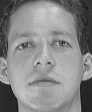

In [49]:
Image.open(f'att/s1/7.pgm').convert('L')

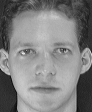

In [50]:
Image.open(f'att/s1/1.pgm').convert('L')

Text(0, 0.5, 'Eigenface 2')

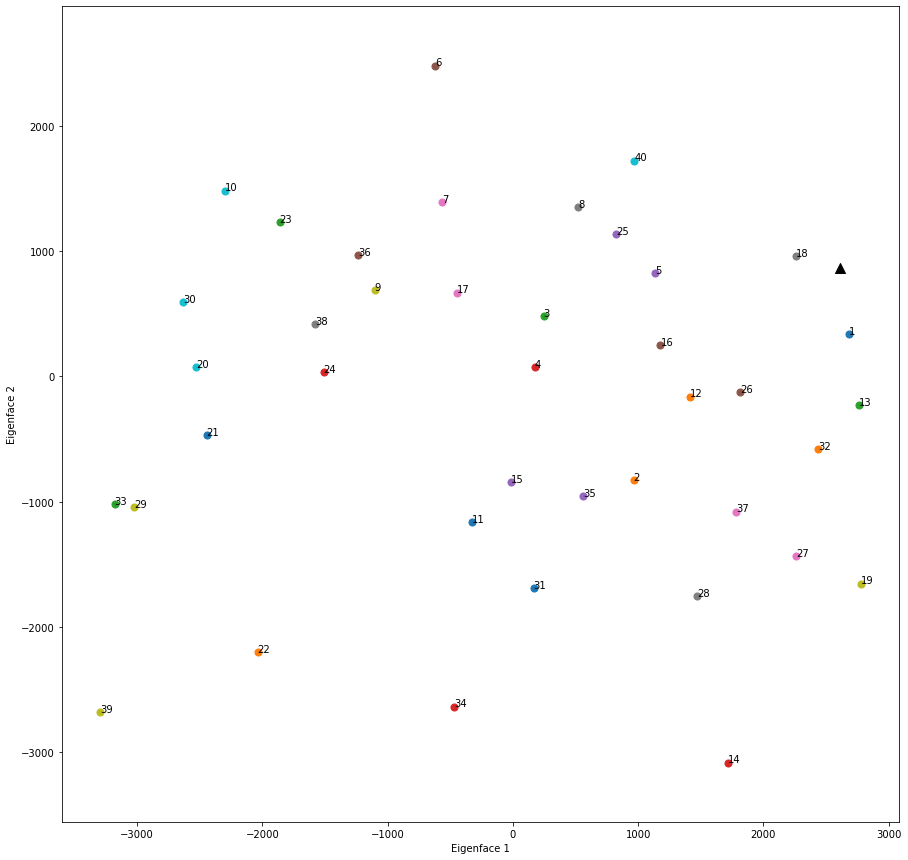

In [51]:
plt.figure(figsize = (15, 15))
plt.axis('equal')
for pasta in range(1, 41):
    imagens = [Image.open(f'att/s{pasta}/{i}.pgm').convert('L') for i in range(3, 4)]
    x, y = np.array([identify(pic) for pic in imagens]).T
    plt.scatter(x, y, s = 50)
    plt.text(x, y, pasta)
plt.scatter(*identify(input_img), label = 'Input image', marker = '^', c = 'k', s = 100)
plt.xlabel('Eigenface 1')
plt.ylabel('Eigenface 2')

In [103]:
np.linalg.norm(coef_proj[242] - test_coef_proj)

4700.229873032058

In [104]:
np.linalg.norm(coef_proj[82] - test_coef_proj)

6641.5741470581825

In [127]:
for image in range(1, 31):
    identifyImage(Image.open(f'att/{image}.pgm').convert('L'), 'euclidian')
    print('\treal person: ', image,'\n')

Para a distância:  euclidian
	Pasta s1
	dist = 2457.8829165129023
	real person:  1 

Para a distância:  euclidian
	Pasta s2
	dist = 825.5244067616856
	real person:  2 

Para a distância:  euclidian
	Pasta s3
	dist = 856.3930108374464
	real person:  3 

Para a distância:  euclidian
	Pasta s4
	dist = 1300.8702876080208
	real person:  4 

Para a distância:  euclidian
	Pasta s40
	dist = 1586.5061344071646
	real person:  5 

Para a distância:  euclidian
	Pasta s6
	dist = 510.7249396339505
	real person:  6 

Para a distância:  euclidian
	Pasta s7
	dist = 1273.4129198122819
	real person:  7 

Para a distância:  euclidian
	Pasta s8
	dist = 1146.9508536155242
	real person:  8 

Para a distância:  euclidian
	Pasta s9
	dist = 1270.4810804901012
	real person:  9 

Para a distância:  euclidian
	Pasta s38
	dist = 2725.5021666912317
	real person:  10 

Para a distância:  euclidian
	Pasta s11
	dist = 1171.2782383172146
	real person:  11 

Para a distância:  euclidian
	Pasta s12
	dist = 797.10155272230

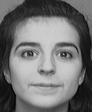

In [114]:
Image.open(f'att/10.pgm').convert('L')

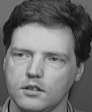

In [110]:
Image.open(f'att/s38/1.pgm').convert('L')

In [108]:
identifyImage(Image.open(f'att/1.pgm').convert('L'), 'mahalanobis')

Falhou no reconhecimento.


array([2606.84996916,  866.92279322])